# Assignment 2: Validation

Name: Karthik Iyer <br>

## Load Data and Define Functions


In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.preprocessing import normalize
from timeit import default_timer as timer 

The log loss function for a binary classification problem is 
$$- \frac{1}{m} \sum_{i = 1}^m \left [s_i \log(p_i) + (1 - s_i) \log (1 -p_i) \right]$$
where $s \in \{0 ,1 \}^m$ is the vector of outcomes and $p \in [0 ,1]^m$ is the probability vector

In [2]:
# Function that reads data

def readdata(filename, datatype):
    fid = open(filename, "rb")
    data = np.fromfile(fid, datatype)
    fid.close()
    return data

# Function used for model assessment

def logloss(x, f, s):
    r = np.dot(f, x)
    val = 0.0
    prob_vector = 1.0/ (1.0 + np.exp(-r))
    for i, p in enumerate(prob_vector):
        if s[i] == 1:
            val += -np.log(p)
        else:
            val += -np.log(1 - p)        
    return val/len(s)

In [3]:
n_features = 50
m_train = 2000
m_validate = 500
m_test = 500

train_f = readdata("train_features.bin", np.float64)
train_s = readdata("train_target.bin", np.float64)
validate_f = readdata("validate_features.bin", np.float64)
validate_s = readdata("validate_target.bin", np.float64)
test_f = readdata("test_features.bin", np.float64)
test_s = readdata("test_target.bin", np.float64)

train_f = np.reshape(train_f, (n_features, m_train)).T 
validate_f = np.reshape(validate_f, (n_features, m_validate)).T
test_f = np.reshape(test_f, (n_features, m_test)).T

# Normalize
train_f = normalize(train_f, axis = 0, norm = 'l2') # column normalization
validate_f = normalize(validate_f, axis = 0, norm = 'l2')
test_f = normalize(test_f, axis = 0, norm = 'l2')

## Define Function for Smooth Part of Logistic Regression
$$\text{lgr}(x) = \sum_{i=1}^m\left\{\log\left(1+\exp{\left\langle f_i, x\right\rangle}\right) - s_i\left\langle f_i,x\right\rangle\right\}$$

First, we code up the logistic regression function, its gradient and hessian for the given logistic regression function.

Note that $$\nabla \text{lgr} = F^T(p - s)$$ where $p = (p_1, p_2,...,p_m)$ with $p_i = \frac{1}{1 + e^{-r_i}}$ and 
$$\nabla^2 \text{lgr}  = F^T D F $$ where $D$ is the $m \times m$ diagonal matrix with $jth$ diagonal entry equal to $p_j (1- p_j)$. 

In [4]:
def lgr_func(x, f, s):
    r = np.dot(f, x)
    sum_of_logs_term = np.sum(np.log(1.0 + np.exp(r)))
    response_term = np.inner(s, r)
    return sum_of_logs_term - response_term
    
    
def lgr_grad(x, f, s):
    r = np.dot(f, x)
    p = 1.0/(1.0 + np.exp(-r)) # Sigmoid function
    return np.dot(f.T, p - s)

def lgr_hess(x, f, s):
    r = np.dot(f, x)
    p1 = 1.0/ (1.0 + np.exp(-r))
    p2 = 1.0 - p1
    p_prime = np.multiply(p1, p2)
    prob_diag_matrix = np.diag(np.ravel(p_prime))
    return np.dot(f.T, np.dot(prob_diag_matrix, f))


## Problem 3: Newton's Method
Fill in the blanks to implement Newton algorithm to solve logistic regression problem,
$$\min_x f_{\ell_2}(x):= \sum_{i=1}^m\left\{\log\left(1+\exp{\left\langle f_i, x\right\rangle}\right) - s_i\left\langle f_i,x\right\rangle\right\} + \frac{\lambda}{2}\|x\|^2$$
where $s_i\in\{0,1\}$ indicates buy or sell.

For this problem we will use real data  from [Numerai](https://numer.ai/leaderboard).
The data set consist of three parts, training data, validation data and test data.

### Train and Validate Data

In [5]:
# Define functions

def lgr_l2_func(x, f, s, lambda_logistic):
    return lgr_func(x, f, s) + 0.5*lambda_logistic*np.inner(x, x)

def lgr_l2_grad(x, f, s, lambda_logistic):
    return lgr_grad(x, f, s) + lambda_logistic*x

def lgr_l2_hess(x, f, s, lambda_logistic):
    return lgr_hess(x, f, s) + lambda_logistic*np.eye(len(x))  

In [6]:
# Define Newton Solver

def Newton(x, f, s, lambda_logistic):
    
    itm = 100
    tol = 1e-12
    g = lgr_l2_grad(x, f, s, lambda_logistic)
    H = lgr_l2_hess(x, f, s, lambda_logistic)
    obj = 0.0
    err = float('Inf')
    for i in range(itm):
        
        # Implement Newton's step. Note that Newton's step involves inverting the Hessian
        # If the Hessian has big size, inverting is not feasible. So, we solve the linear system
        # H*delta_x = - g and set x = x + delta_x. This is mathematically equivalent to what we 
        # set out to do. 
        
        delta_x = LA.solve(H, -g)
        x = x + delta_x
        g = lgr_l2_grad(x, f, s, lambda_logistic)
        H = lgr_l2_hess(x, f, s, lambda_logistic)
        err = LA.norm(g, 2)
        if err < tol:
            break        
    return x

In [7]:
lambda_logistic_set = np.linspace(0.01, 0.001, num = 21)
x1_set = np.zeros((len(lambda_logistic_set), n_features))
v1_set = np.zeros(len(lambda_logistic_set))

# Main part of Newton's iteration. Let's also time this snippet!
start = timer()
for i, lambda_logistic in enumerate(lambda_logistic_set):
    x1 = x1_set[i]
    if i > 0:
        x1 = x1_set[i-1]
    x1_set[i] = Newton(x1, train_f, train_s, lambda_logistic)
    v1_set[i] = logloss(x1_set[i], validate_f, validate_s)
end = timer()

In [8]:
end - start # answer in seconds

1.7197814271067422

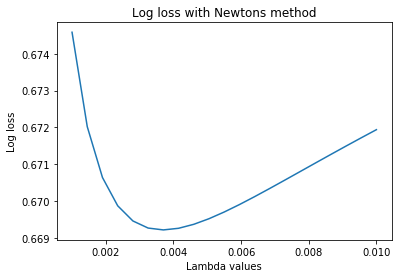

In [9]:
plt.plot(lambda_logistic_set, v1_set)
plt.xlabel('Lambda values')
plt.ylabel('Log loss')
plt.title('Log loss with Newtons method')
plt.show()

In [10]:
# Choose the index with smallest validation prediction error. 
ind = np.argmin(v1_set)

# Choose the regularization parameter that gives the lowest prediction error.
lambda_one = lambda_logistic_set[ind]

# Threshold validation met as prediction error is smallest. Exit the training.
x1 = x1_set[ind]

### Test Data

In [11]:
# Compute the test log loss
logloss(x1, test_f, test_s)

0.69642675615051364

## Problem 4: FISTA
Implement the FISTA algorithm to solve logistic regression problem,
$$\min_x \sum_{i=1}^m\left\{\log\left(1+\exp{\left\langle f_i, x\right\rangle}\right) - s_i\left\langle f_i,x\right\rangle\right\} + \lambda g(x).$$
Choose your favorite $g$ and try to get the test error as low as possible.

We choose the following 3 different $g$ and run FISTA on $f(x) + \lambda g_k(x)$. 

 $g_1 = t ||x||_1 + (1-t)||x||^2$.
 
 $g_2 = ||x||_2.$
 
 $g_3 = \rho_c(x)$, where $\rho_c$ is the Huber function with c = 40. 
 

In [12]:
# Define functions and hyper-parameters.

def lgr_func_with_g1(x, f, s, t = 0):
    smooth_part = lgr_func(x, f, s)
    g1 = t*LA.norm(x, 1) + (1- t)*np.inner(x, x)
    return smooth_part + g1

def lgr_func_with_g2(x, f, s):
    smooth_part = lgr_func(x, f, s)
    g2 =  LA.norm(x, 2)
    return smooth_part + g2


c = 40.0 # Tuning hyper-parameter for Huber
def lgr_func_with_g3(x, f, s):
    smooth_part = lgr_func(x, f, s)
    val = 0.0
    for i in range(len(x)):
        if x[i] > c:
            val += c*abs(x[i]) - 0.5*c*c
        else:
            val += 0.5*x[i]*x[i]
    return smooth_part + val

In [13]:
# Compute proxes

def prox_g1(x, kappa, t = 0):  
    z = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] > kappa*t:
            z[i] = (x[i] - kappa*t)/(1.0 + 2*kappa*(1 - t))
        elif x[i] < -kappa*t:
            z[i] = (x[i] + kappa*t)/(1.0 + 2*kappa*(1 - t))
    return z 

def prox_g2(x, kappa):
    z = np.zeros(len(x))
    if LA.norm(x) > kappa:
        z = x*(1 - (kappa/(LA.norm(x))))
    return z

def prox_g3(x, kappa):
    z = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < -c*(1.0 + kappa):
            z[i] = x[i] + c*kappa
        elif x[i] > c*(1.0 + kappa):
            z[i] = x[i] - c*kappa
        else:
            z[i] = x[i]/(1.0 + kappa)
    return z 

In [14]:
# Step size for FISTA
beta = 0.25*LA.norm(train_f)*LA.norm(train_f) # beta for smooth part
alpha = 1.0/ beta

In [15]:
# FISTA solver

def FISTA(x, f, s, lambda_logistic, prox_friendly_g, itm = 2000, tol = 1e-6, t= 0):
    count, a = 0, 1.0
    y_old = x
    y = x
    err = float('Inf')
    while count < itm:
        x_old = x
        y_old = y
        
        # Step 1: Update x
        
        # Calculate prox for lambda*g1 and update x
        if prox_friendly_g == 1: 
            kappa = lambda_logistic*alpha
            x = prox_g1(y_old - alpha*lgr_grad(y_old, f, s), kappa, t)
            
        # Calculate prox for lambda*g2 and update x    
        elif prox_friendly_g == 2:  
            kappa = lambda_logistic/beta
            x = prox_g2(y_old - alpha*lgr_grad(y_old, f, s), kappa)
        
        # Calculate prox for lambda*g3 and update x
        elif prox_friendly_g == 3: 
            kappa = lambda_logistic/beta
            x = prox_g3(y_old - alpha*lgr_grad(y_old, f, s), kappa)
            
        # Step 2: Update a
        a_new = 0.5*(1 + np.sqrt(1 + 4*a*a))
        
        # Step 3: Update y
        ratio_factor = (a - 1)/a_new
        y = x + ratio_factor*(x - x_old)
        err = LA.norm(x - x_old)
        a = a_new
        if err < tol:
            break   
        count += 1
    return x

Next we run the FISTA and validate over $\lambda$. The default value of $t$ is None. If $t$ is specified, for each value of $t$, the validation function computes the best log loss over $\lambda$ and returns a tuple of best test log loss and the corresponding $\lambda$. Otherwise, the validation function just returns the best test log loss over all $\lambda$. 

In [16]:
def validation_over_t(prox_friendly_g, lambda_logistic_set, t = None):
    
    x2_set = np.zeros((len(lambda_logistic_set), n_features))
    v2_set = np.zeros(len(lambda_logistic_set))
    
    for i, lambda_logistic in enumerate(lambda_logistic_set):
        x2 = x2_set[i]
        if i > 0:
            x2 = x2_set[i-1]
        x2_set[i] = FISTA(x2, train_f, train_s, lambda_logistic, prox_friendly_g, t = t)
        v2_set[i] = logloss(x2_set[i], validate_f, validate_s)
        
    ind = np.argmin(v2_set)
    x2 = x2_set[ind]
    return ((logloss(x2, test_f, test_s), lambda_logistic_set[ind])) 

In [17]:
t = np.linspace(0, 1, num = 30)
lambda_logistic_set = np.linspace(0.01, 0.001, num = 21)
#lambda_logistic_set = np.linspace(0.01, 0.001, num = 100)

 ### Compute the test log loss for $g_1$.

In [18]:
prox_friendly_g = 1
log_loss_test = np.zeros(len(t))
best_lambda_for_t = np.zeros(len(t))
start = timer()

for i, t0 in enumerate(t):
    validation_result = validation_over_t(prox_friendly_g, lambda_logistic_set, t0)
    log_loss_test[i]  = validation_result[0]
    best_lambda_for_t[i] = validation_result[1]
    
end = timer()

In [19]:
idx = np.argmin(log_loss_test)
(t[idx], best_lambda_for_t[idx])

(0.13793103448275862, 0.0023499999999999997)

In [20]:
end - start # time in seconds

236.13186864293056

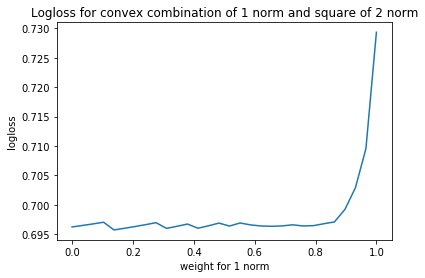

In [23]:
# Plot logloss for g1

plt.plot(t, log_loss_test)
plt.title('Logloss for convex combination of 1 norm and square of 2 norm')
plt.xlabel('weight for 1 norm')
plt.ylabel('logloss')
plt.show()

Note the more weight in the 1 norm worsens the log loss. 

In [25]:
np.min(log_loss_test)

0.69572123490420545

### Compute the test log loss for $g_2$.

In [26]:
prox_friendly_g = 2 # ||x||_2 penalty
validation_over_t(prox_friendly_g, lambda_logistic_set)[0]

0.74950295813809853

### Compute the test log loss for $g_3$.

In [27]:
prox_friendly_g = 3 # Huber penalty 
validation_over_t(prox_friendly_g, lambda_logistic_set)[0]

0.69642737105302122